In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import sys
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
from utils import citibike_helpers
import numpy as np
import pandas as pd  #requirement comes with anaconda
import datetime 
from datetime import datetime as dt
import seaborn as sns
import operator
import networkx as nx
import community #requires separate install -  pip install python-louvain
import warnings
warnings.filterwarnings('ignore')

In [2]:
inputfile="../datasets/citibike/201701-citibike-tripdata.csv.gz"
df=citibike_helpers.load_citibike_data(inputfile)
df.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2


In [3]:
unique_start_stations=citibike_helpers.get_unique_column_values(df,'Start Station ID')
unique_end_stations=citibike_helpers.get_unique_column_values(df,'End Station ID')
station_ids=set(unique_start_stations).union(set(unique_end_stations))
print(unique_start_stations.shape)
print(unique_end_stations.shape)
print("Stations that no one ever starts at but they only end at",set(unique_end_stations).difference(set(unique_start_stations)))

(609,)
(612,)
Stations that no one ever starts at but they only end at {3250, 3447, 3183}


In [4]:
inputfile="../datasets/citibike/201701-citibike-tripdata.csv.gz"
df = citibike_helpers.load_citibike_data(inputfile)
df = citibike_helpers.calculate_trip_durations_citibike(df)
#Here we focus on a subset of "interesting" trips with duration between 5 and 120 minutes.
subset_trips=df[(df['Trip Duration Minutes']>5) & (df['Trip Duration Minutes']<120)]

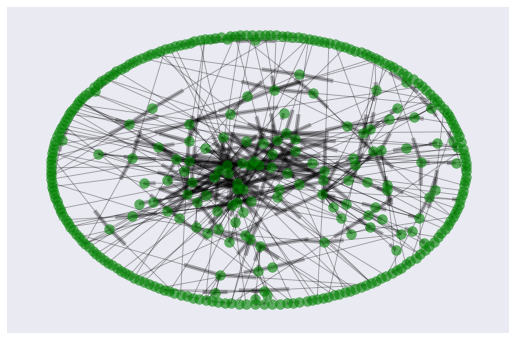

In [5]:
edges_with_weights=citibike_helpers.infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=citibike_helpers.create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')
fig_path="figures/citibike_top_"+str(_thr*100)+"_stn_stn_network.png"
citibike_helpers.plot_network(g,title="",edgealpha=0.3,nodesize=100,savefig=True,filename=fig_path)

In [6]:
print(nx.info(g.to_undirected()))

Name: 
Type: Graph
Number of nodes: 329
Number of edges: 425
Average degree:   2.5836


# Laplacian Matrix
First 8 rows and columns of laplacian matrix for the graph. Please note that, we round the values in the Laplacian matrix just for demonstration purposes, you should not round these values in real world.

In [7]:
und_g = g.to_undirected()
lpm = nx.laplacian_matrix(und_g)
print(np.round(lpm,2)[0:8,0:8].todense()) 

[[  32.53  -21.98    0.      0.      0.      0.      0.      0.  ]
 [ -21.98  144.52    0.      0.      0.      0.      0.      0.  ]
 [   0.      0.     16.72  -16.72    0.      0.      0.      0.  ]
 [   0.      0.    -16.72   50.41    0.      0.      0.      0.  ]
 [   0.      0.      0.      0.     84.05   -6.74    0.      0.  ]
 [   0.      0.      0.      0.     -6.74   48.61    0.      0.  ]
 [   0.      0.      0.      0.      0.      0.     16.12   -3.52]
 [   0.      0.      0.      0.      0.      0.     -3.52   15.93]]


# Modularity Matrix
First 8 rows and columns of laplacian matrix for the graph. Please note that, we round the values in the Laplacian matrix just for demonstration purposes, you should not round these values in real world.

In [8]:
modularity_mat = nx.directed_modularity_matrix(g)
print(np.round(modularity_mat,2)[0:8,0:8])

[[  0.    12.27   0.    -3.39  -4.61  -2.1   -1.08  -1.8 ]
 [  0.    -9.8    0.    -3.42  -4.65  -2.12  -1.09  -1.82]
 [  0.    -4.99   0.    14.98  -2.37  -1.08  -0.56  -0.93]
 [  0.    -2.74   0.    -0.96  -1.3   -0.59  -0.31  -0.51]
 [  0.   -17.69   0.    -6.17  -8.4   11.18  -1.97  -3.28]
 [  0.   -10.65   0.    -3.71   1.69  -2.3   -1.19  -1.97]
 [  0.    -7.35   0.    -2.56  -3.49  -1.59  -0.82  13.03]
 [  0.    -1.05   0.    -0.37  -0.5   -0.23   3.4   -0.19]]


In [9]:
modulariy_ev = sorted(nx.linalg.spectrum.modularity_spectrum(g),reverse=True)
laplacian_ev = sorted(nx.linalg.spectrum.laplacian_spectrum(und_g),reverse=True)

In [10]:
print('top 10 eigenvalues for modularity matrix and laplacian matrix:')
for k,v in zip(modulariy_ev[0:10],laplacian_ev[0:10]):
    print('modularity matrix: {}\tlaplacian matrix: {}'.format(k,v))

top 10 eigenvalues for modularity matrix and laplacian matrix:
modularity matrix: (24.884450634669303+0j)	laplacian matrix: 152.46585906860633
modularity matrix: (18.053157893940785+0j)	laplacian matrix: 94.97437525867758
modularity matrix: (12.158568982235218+0j)	laplacian matrix: 81.33978394533351
modularity matrix: (10.438148293701495+0j)	laplacian matrix: 77.526694660713
modularity matrix: (9.698229055423282+0j)	laplacian matrix: 62.84397803008562
modularity matrix: (8.951271306911162+0j)	laplacian matrix: 60.043752412344524
modularity matrix: (6.853564242140381+0j)	laplacian matrix: 57.41034945976201
modularity matrix: (6.65780493800537+0j)	laplacian matrix: 51.25185226130351
modularity matrix: (6.417871451181256+0j)	laplacian matrix: 50.1655500362958
modularity matrix: (5.911792626175153+0j)	laplacian matrix: 49.17415460736111


# Modularity value

In [11]:
part = community.best_partition(und_g)
print(community.modularity(part, und_g))

0.8000819541461358


# Connected Components

In [12]:
sub_graphs = nx.connected_component_subgraphs(und_g)
print('number of connected components: ' + str(len([k for k in sub_graphs])))

number of connected components: 17


# Giant Connected Component

In [13]:
Gc = max(nx.connected_component_subgraphs(und_g), key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(nx.info(Gc))

Name: GCC
Type: Graph
Number of nodes: 295
Number of edges: 407
Average degree:   2.7593


# Community Detection
We find the communities for the Giant Connected Component

Number of partitions: 295


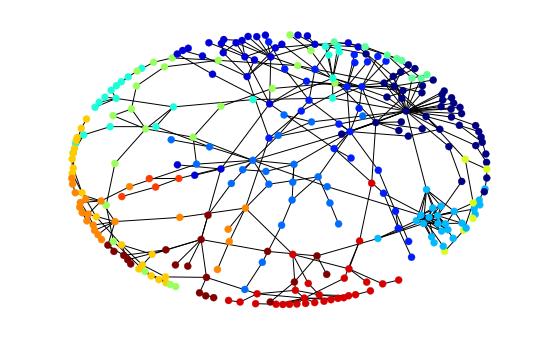

In [14]:
plt.figure(figsize=(9,6))
pos = nx.spring_layout(Gc,iterations=200)
partition = community.best_partition(Gc)
print('Number of partitions: {}'.format(len(partition)))
values = [partition.get(node) for node in Gc.nodes()]
plt.axis("off")
nx.draw_networkx(Gc, pos = pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 50, with_labels = False)

# Spectral Clustering: Binary Clustering
In binary clustering, we just use the second smallest Eigenvector to decide the labels of nodes.

In [15]:
L = nx.laplacian_matrix(Gc)
eig_values, eig_vectors = np.linalg.eigh(L.todense()) # Eigen values sorted from smallest to biggest

In [16]:
f = eig_vectors[:,1] # use the second smallest Eigen vector for spectral clustering

In [17]:
labels = np.ravel(np.sign(f)) # decides the label of each node

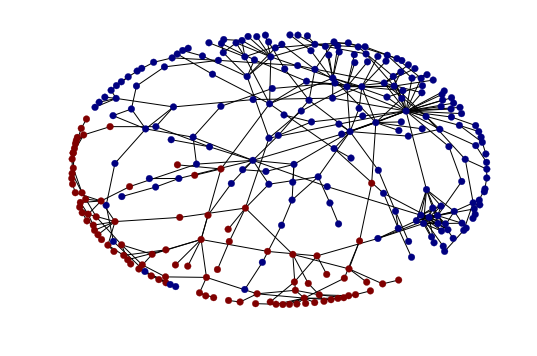

In [18]:
fig = plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos,node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)

# Spectral Clustering: Multiple Clusters
To find more than 2 clusters, we can use all the Eigenvectors (except the first one) of the Laplacian matrix. Please note that these eigenvectors are sorted based on their respective eigenvalues

In [19]:
import scipy.cluster.vq as vq
k=4
means, labels = vq.kmeans2(eig_vectors[:,1:k], k)

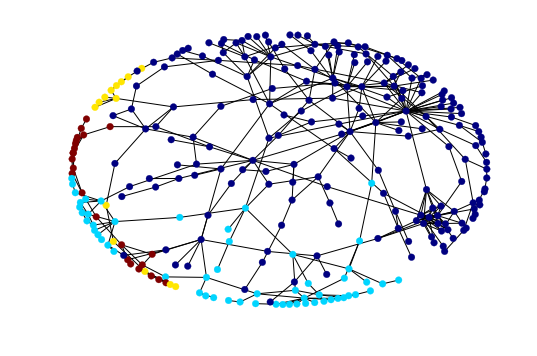

In [20]:
fig = plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos, node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)

# Agglomerative Hierarchical Clustering (AHC)
We use complete link (Creates AHC using farthest point linkage) for this example.

In [21]:
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance

# LVL 1: Original Graph

original graph (lvl 1) info:
Name: GCC
Type: Graph
Number of nodes: 295
Number of edges: 407
Average degree:   2.7593


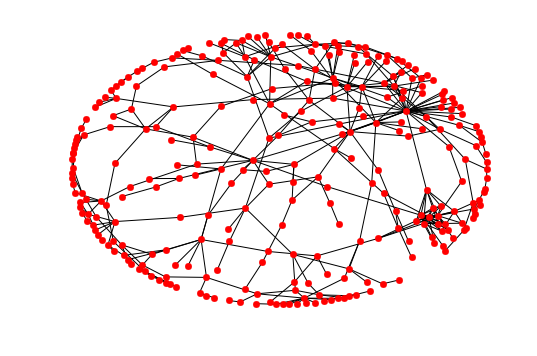

In [22]:
fig=plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos, node_size=45, with_labels = False)
print('original graph (lvl 1) info:')
print(nx.info(Gc))

In [23]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=1.15))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(n)
    return list(partition.values())

In [24]:
def draw_hc(G, lvl):
    plt.close()
    plt.ion()
    fig=plt.figure(figsize=(9,6))
    plt.axis("off")
    G=nx.convert_node_labels_to_integers(G)
    partitions=create_hc(G)
    BM=nx.blockmodel(G,partitions)
    node_size=[BM.node[x]['nnodes']*10 for x in BM.nodes()]
    edge_width=[1 for (u,v,d) in BM.edges(data=True)]
    pos = nx.spring_layout(BM,iterations=200)
    nx.draw(BM,pos,node_size=node_size,width=edge_width,with_labels=False)
    plt.title('Agglomerative Hierarchical Clustering for Citibike Network, lvl {}'.format(lvl))
    plt.show()
    return BM, partitions

# AGH: level by level clustering

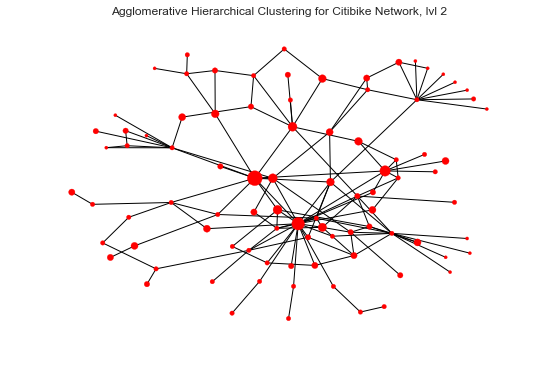

LVL 2 cluster info:
Name: 
Type: Graph
Number of nodes: 89
Number of edges: 142
Average degree:   3.1910
sample of partitions:
[[0, 1, 138, 220, 260, 292], [2, 3, 190], [4, 121, 122], [5, 149, 150, 275], [6, 107, 109, 111, 112, 113, 115, 184]]


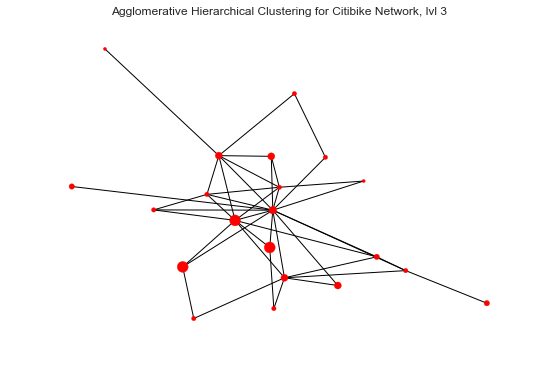

LVL 3 cluster info:
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 42
Average degree:   4.0000
sample of partitions:
[[0, 5, 14, 15, 26, 27, 28, 29, 30, 37, 65, 83], [1, 2], [3, 6], [4, 7, 10, 11, 22, 32], [8, 45, 46]]


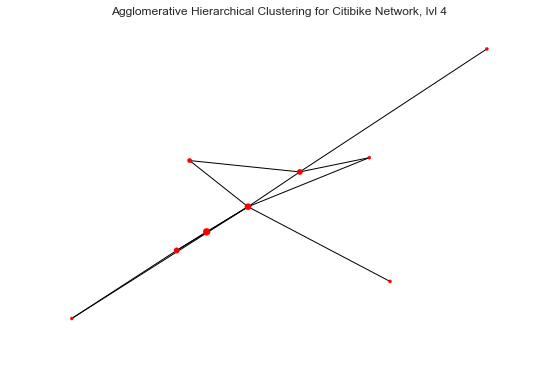

LVL 4 cluster info:
Name: 
Type: Graph
Number of nodes: 9
Number of edges: 12
Average degree:   2.6667
sample of partitions:
[[0, 1, 2, 3], [4, 6, 14], [5, 7, 8], [9, 10], [11, 15, 16, 17, 18]]


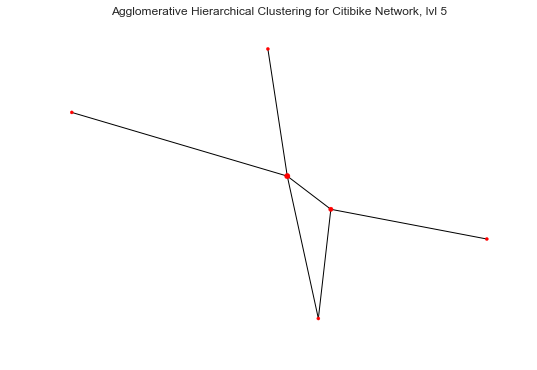

LVL 5 cluster info:
Name: 
Type: Graph
Number of nodes: 6
Number of edges: 6
Average degree:   2.0000
sample of partitions:
[[0, 1, 4], [2, 3], [5], [6], [7]]


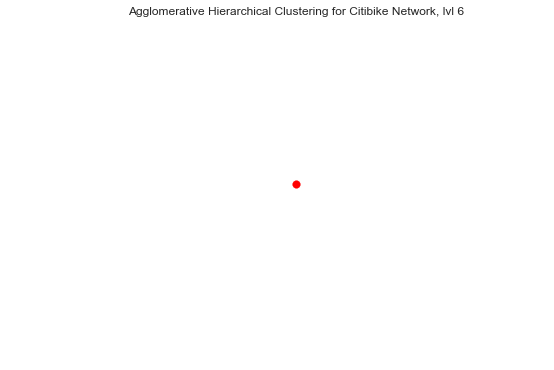

LVL 6 cluster info:
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
sample of partitions:
[[0, 1, 2, 3, 4, 5]]


In [25]:
H= Gc.copy()
lvl = 2
while(H.number_of_nodes()>1):
    H, partitions = draw_hc(H, lvl)
    print('LVL {} cluster info:'.format(lvl))
    print(nx.info(H))
    print('sample of partitions:')
    print(partitions[0:5])
    lvl +=1

# Divisive Hierarchial Clustering

In [26]:
H = Gc.copy()
partitions = {}
partition_graph = {}
lvl = 1
# adding the original graph as the first lvl
sub_graphs = nx.connected_component_subgraphs(H)
partitions.update({lvl:[k.nodes() for k in sub_graphs]})
while(nx.number_connected_components(H)!=H.number_of_nodes()):
    eb = nx.edge_betweenness(H) # use edge betweenness to find the best edge to remove
    sorted_eb = sorted(eb.items(), reverse=True, key=operator.itemgetter(1))
    k,v = sorted_eb[0][0]
    ncc_before = nx.number_connected_components(H)
    H.remove_edge(k,v)
    ncc_after = nx.number_connected_components(H)
    if ncc_before == ncc_after: continue
    else:
        lvl +=1
        sub_graphs = nx.connected_component_subgraphs(H)
        partitions.update({lvl:[k.nodes() for k in sub_graphs]})
        partition_graph.update({lvl:H.copy()})

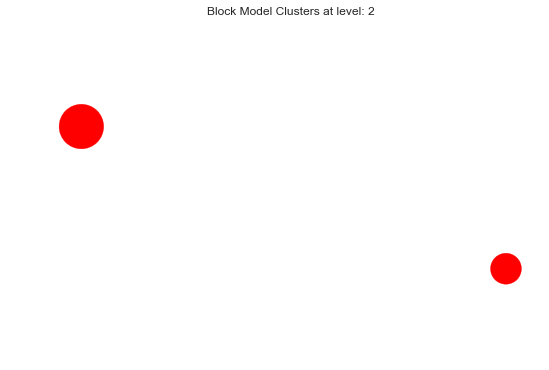

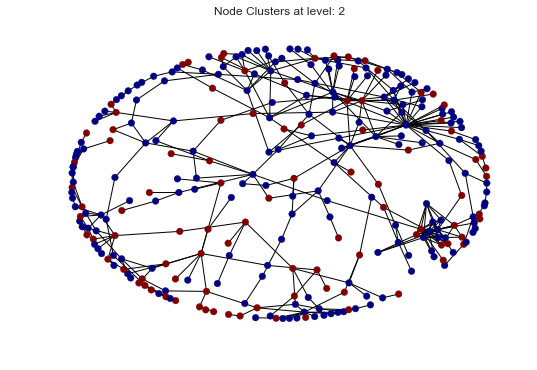

In [27]:
lvl = 2
PG = partition_graph[lvl]
part = partitions[lvl]
labels = np.ones(PG.number_of_nodes())

for i,p in enumerate(part):
    for k in p:
        labels[k]=int(i)

fig = plt.figure(figsize=(9,6))
BM=nx.blockmodel(PG, part)
node_size=[BM.node[x]['nnodes']*10 for x in BM.nodes()]
edge_width=[1 for (u,v,d) in BM.edges(data=True)]
BM_pos = nx.spring_layout(BM,iterations=200)
plt.axis("off")
plt.title("Block Model Clusters at level: {}".format(lvl))
nx.draw(BM, BM_pos,node_size=node_size,width=edge_width,with_labels=False)
fig = plt.figure(figsize=(9,6))
plt.axis("off")
plt.title("Node Clusters at level: {}".format(lvl))
nx.draw_networkx(PG, pos, node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)